# Split data into multiple rows with iterators

Transform a single document, video, image, or audio file into multiple rows for granular processing.

**What's in this recipe:**

- Split documents into text chunks for RAG
- Extract frames or segments from videos
- Tile images for high-resolution analysis
- Chunk audio files for transcription

## Problem

You have documents, videos, or text that you need to break into smaller pieces for processing. A PDF needs to be split into chunks for retrieval-augmented generation. A video needs individual frames for analysis. Text needs to be divided into sentences or sliding windows.

You need a way to transform one source row into multiple output rows automatically.

## Solution

You create views with iterator functions that split source data into multiple rows. Pixeltable provides built-in iterators for documents, videos, images, audio, and strings.

### Setup

In [ ]:
%pip install -qU pixeltable spacy tiktoken

In [47]:
import pixeltable as pxt

### Split documents into chunks

Use `document_splitter` to break documents (PDF, HTML, Markdown, TXT) into text chunks.

In [48]:
from pixeltable.functions.document import document_splitter

pxt.drop_dir('split_demo', force=True)
pxt.create_dir('split_demo')

docs = pxt.create_table('split_demo.docs', {'doc': pxt.Document})
docs.insert([{'doc': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/rag-demo/Jefferson-Amazon.pdf'}])

Created directory 'split_demo'.
Created table 'docs'.
Inserting rows into `docs`: 1 rows [00:00, 821.77 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

In [49]:
chunks = pxt.create_view(
    'split_demo.doc_chunks',
    docs,
    iterator=document_splitter(docs.doc, separators='sentence,token_limit', limit=300)
)
chunks.select(chunks.text).limit(3).collect()

Inserting rows into `doc_chunks`: 139 rows [00:00, 42530.51 rows/s]


text
FINANCIAL SONAR™: REALITY RADAR ON COMPANY PERFORMANCE NASDAQGSAMZN AMAZON.COM
INC. REGION NORTH AMERICA INDUSTRY INTERNET AND DIRECT MARKETING RETAIL SELL OVERALL RATING FOR 1ST QUARTER 2024 www.jeffersonresearch.com
"© 2024 Jefferson Research & Management Report prepared on June 21, 2024 OUR EVALUATION OF AMZN Amazon.com Inc. is showing strong Earnings Quality and Balance Sheet Quality, but Valuation suggests a higher amount of price risk, and Cash Flow Quality and Operating Efficiency are both weak."


**Available separators:**

- `heading` — Split on HTML/Markdown headings
- `sentence` — Split on sentence boundaries (requires spacy)
- `token_limit` — Split by token count (requires tiktoken)
- `char_limit` — Split by character count
- `page` — Split by page (PDF only)

[SDK Reference: document_splitter](https://docs.pixeltable.com/sdk/latest/document)

### Extract frames from videos

Use `frame_iterator` to extract frames at specified intervals.

In [50]:
from pixeltable.functions.video import frame_iterator

videos = pxt.create_table('split_demo.videos', {'video': pxt.Video})
videos.insert([{'video': 'https://github.com/pixeltable/pixeltable/raw/main/docs/resources/bangkok.mp4'}])

Created table 'videos'.
Inserting rows into `videos`: 1 rows [00:00, 889.00 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

Inserting rows into `frames`: 19 rows [00:00, 9346.91 rows/s]


frame_idx,pos_msec,frame
0,0.,
1,1000.,
2,2000.,

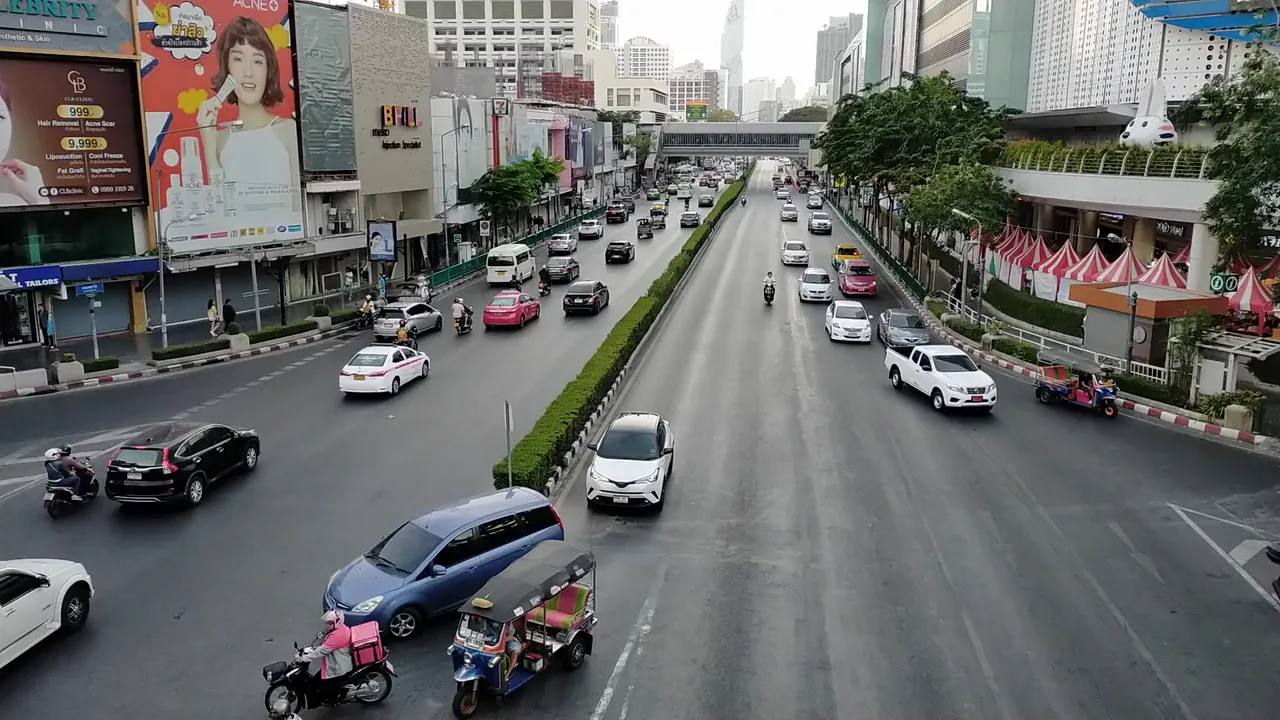
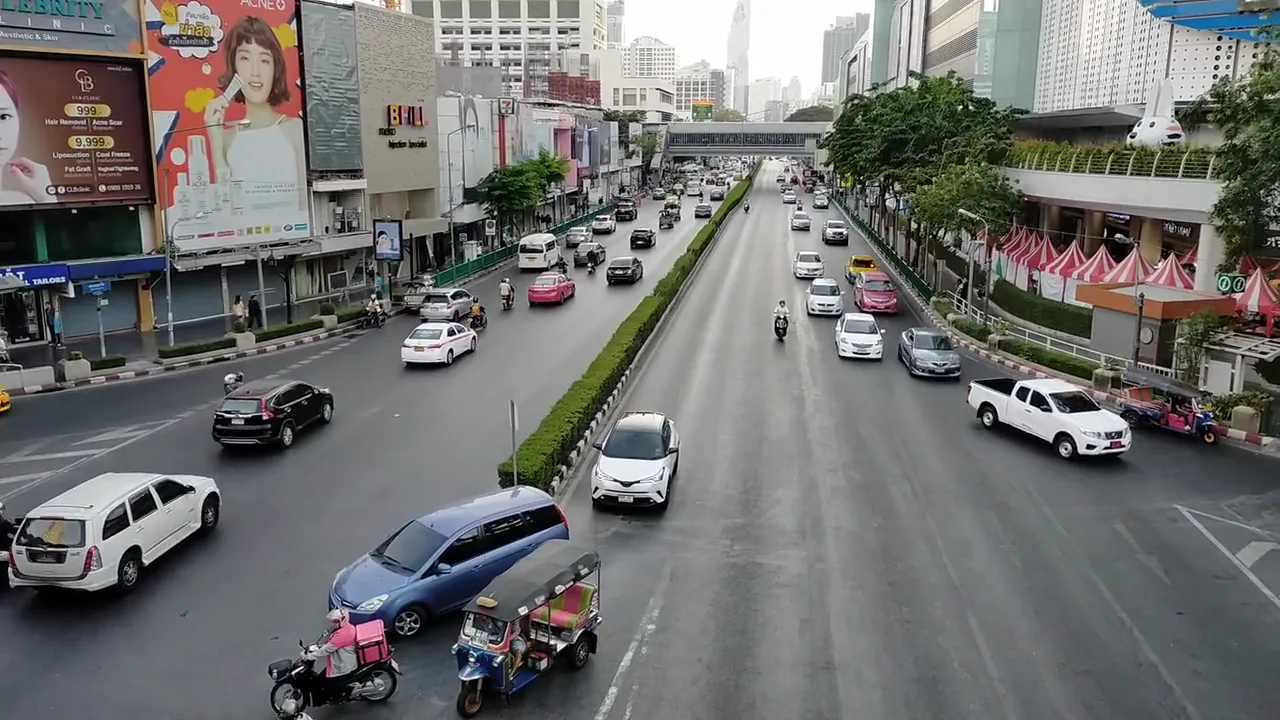
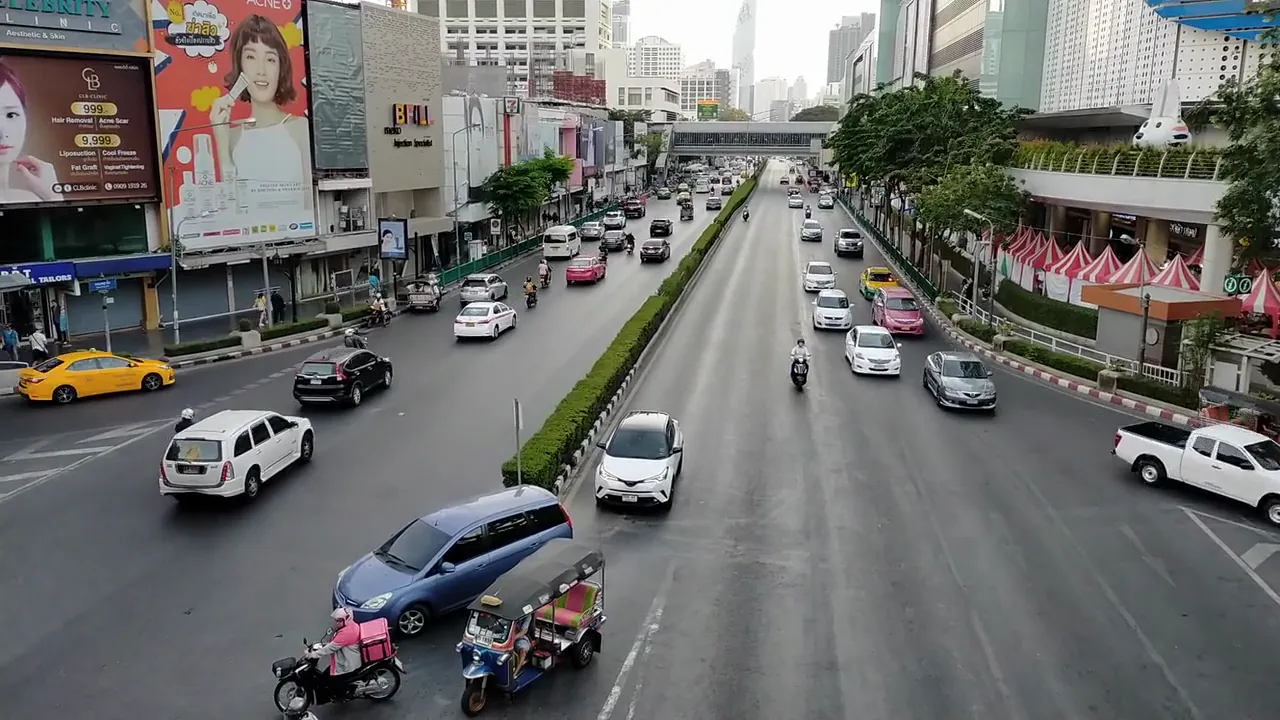

In [51]:
frames = pxt.create_view(
    'split_demo.frames',
    videos,
    iterator=frame_iterator(videos.video, fps=1.0)
)
frames.select(frames.frame_idx, frames.pos_msec, frames.frame).limit(3).collect()

**frame_iterator options:**

- `fps` — Frames per second to extract
- `num_frames` — Extract exact number of frames (evenly spaced)
- `keyframes_only` — Extract only keyframes

[SDK Reference: frame_iterator](https://docs.pixeltable.com/sdk/latest/video)

### Split videos into segments

Use `video_splitter` to divide videos into smaller clips.


Inserting rows into `segments`: 4 rows [00:00, 2046.00 rows/s]


segment_start,segment_end,video_segment
0.,5.,
5.,10.,
10.,15.,

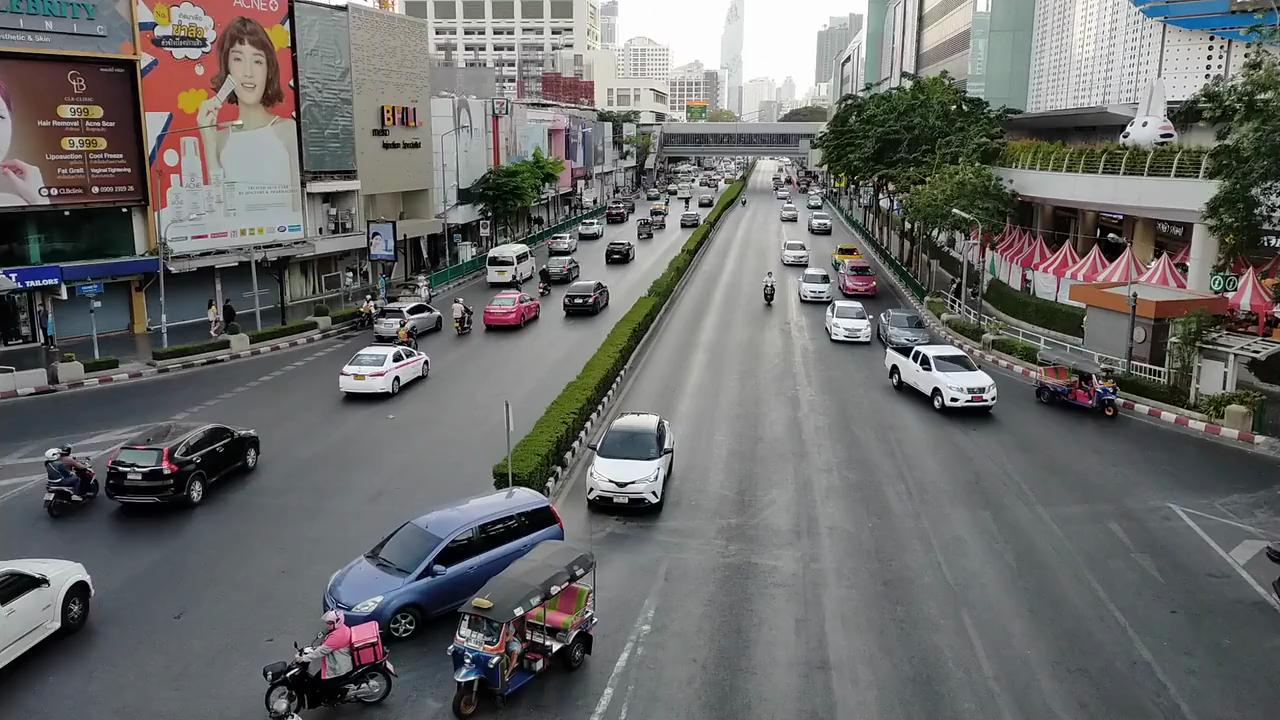
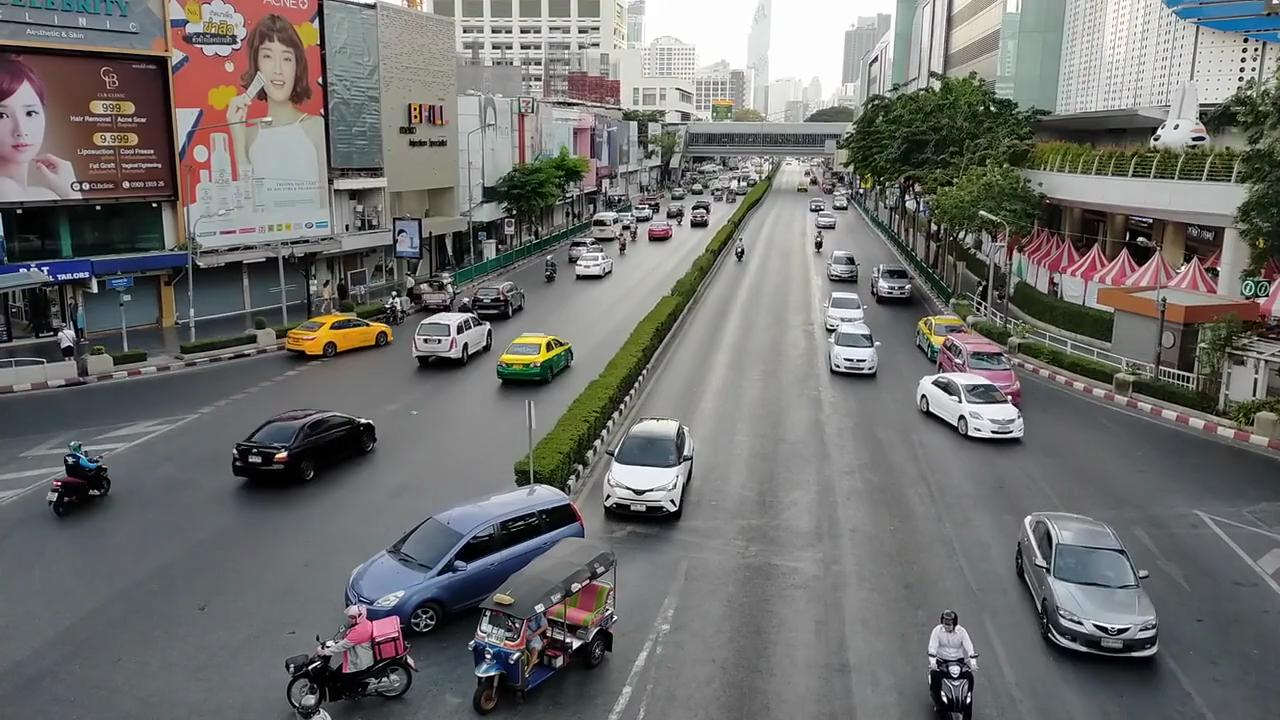
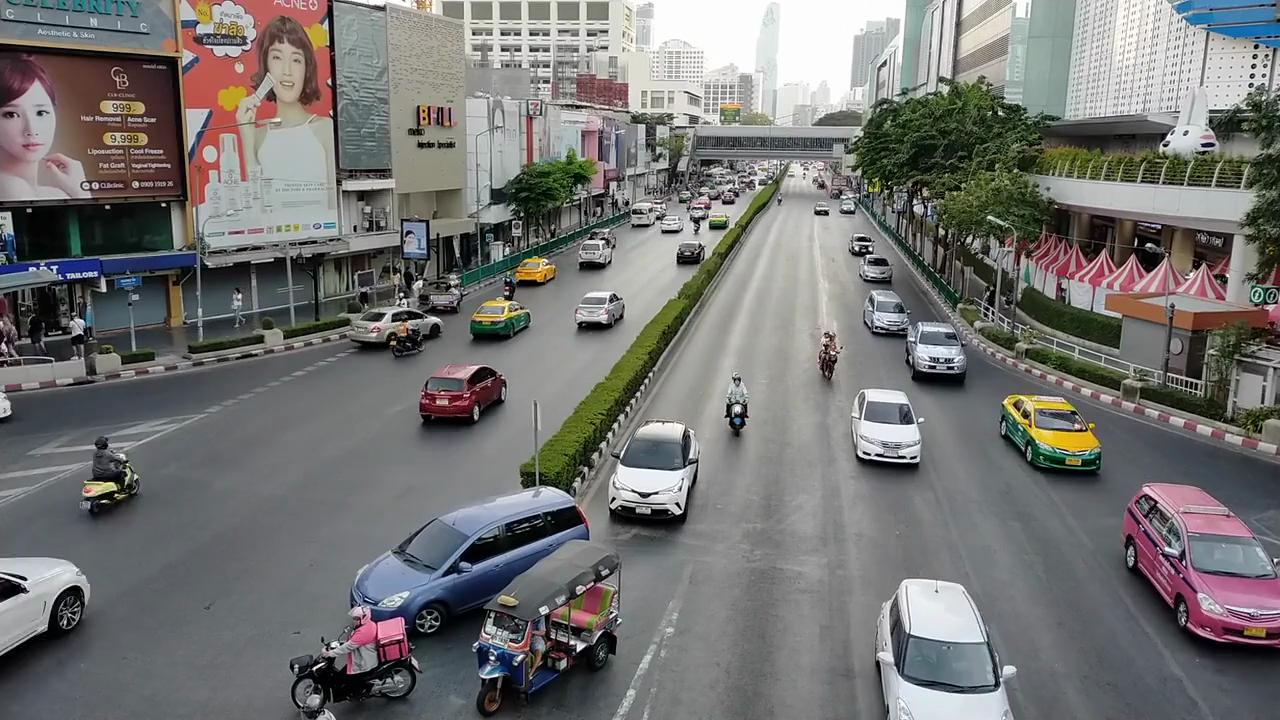

In [52]:
from pixeltable.functions.video import video_splitter

segments = pxt.create_view(
    'split_demo.segments',
    videos,
    iterator=video_splitter(videos.video, duration=5.0, min_segment_duration=1.0)
)
segments.select(segments.segment_start, segments.segment_end, segments.video_segment).limit(3).collect()

**video_splitter options:**

- `duration` — Duration of each segment in seconds
- `overlap` — Overlap between segments in seconds
- `min_segment_duration` — Drop last segment if shorter than this

[SDK Reference: video_splitter](https://docs.pixeltable.com/sdk/latest/video)


### Split strings into sentences

Use `string_splitter` to divide text into sentences.

In [53]:
from pixeltable.functions.string import string_splitter

texts = pxt.create_table('split_demo.texts', {'content': pxt.String})
texts.insert([{'content': 'AI data infrastructure simplifies ML workflows. Declarative pipelines update incrementally. This makes development faster and more maintainable.'}])

Created table 'texts'.
Inserting rows into `texts`: 1 rows [00:00, 814.27 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 1 value computed.

In [54]:
sentences = pxt.create_view(
    'split_demo.sentences',
    texts,
    iterator=string_splitter(texts.content, separators='sentence')
)
sentences.select(sentences.text).collect()

Inserting rows into `sentences`: 3 rows [00:00, 2225.49 rows/s]


text
AI data infrastructure simplifies ML workflows.
Declarative pipelines update incrementally.
This makes development faster and more maintainable.


[SDK Reference: string_splitter](https://docs.pixeltable.com/sdk/latest/string)


### Tile images for analysis

Use `tile_iterator` to divide large images into a grid of smaller tiles. This is useful for processing high-resolution images that are too large to analyze at once, or for running object detection on different regions.

In [55]:
from pixeltable.functions.image import tile_iterator

images = pxt.create_table('split_demo.images', {'image': pxt.Image})
images.insert([{'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/pixeltable-logo-large.png'}])

Created table 'images'.
Inserting rows into `images`: 1 rows [00:00, 825.81 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

In [56]:
tiles = pxt.create_view(
    'split_demo.tiles',
    images,
    iterator=tile_iterator(images.image, tile_size=(100, 100))
)

Inserting rows into `tiles`: 176 rows [00:00, 40174.01 rows/s]


**tile_iterator options:**

- `tile_size` — Size of each tile as `(width, height)`
- `overlap` — Overlap between adjacent tiles as `(width, height)`

[SDK Reference: tile_iterator](https://docs.pixeltable.com/sdk/latest/image)


tile_coord,tile
"[21, 5]",
"[3, 7]",
"[3, 5]",
"[6, 7]",

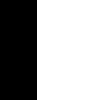
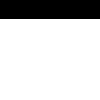
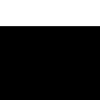
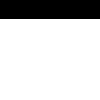

In [57]:
tiles.select(tiles.tile_coord, tiles.tile).sample(n=4).collect()

### Split audio into chunks

Use `audio_splitter` to divide audio files into time-based chunks for transcription or analysis.

In [58]:
from pixeltable.functions.audio import audio_splitter

audio = pxt.create_table('split_demo.audio', {'audio': pxt.Audio})
audio.insert([{'audio': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/10-minute%20tour%20of%20Pixeltable.mp3'}])

Created table 'audio'.
Inserting rows into `audio`: 1 rows [00:00, 777.01 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

In [59]:
audio_chunks = pxt.create_view(
    'split_demo.audio_chunks',
    audio,
    iterator=audio_splitter(audio.audio, chunk_duration_sec=30.0, overlap_sec=2.0)
)
audio_chunks.select(audio_chunks.start_time_sec, audio_chunks.end_time_sec).limit(5).collect()


Inserting rows into `audio_chunks`: 11 rows [00:00, 7493.48 rows/s]


start_time_sec,end_time_sec
0.,29.989
28.003,57.992
56.007,85.995
84.01,113.998
112.013,141.976


**audio_splitter options:**

- `chunk_duration_sec` — Duration of each chunk in seconds
- `overlap_sec` — Overlap between chunks in seconds
- `min_chunk_duration_sec` — Drop last chunk if shorter than this

[SDK Reference: audio_splitter](https://docs.pixeltable.com/sdk/latest/audio)

## See also

- [Split documents for RAG](https://docs.pixeltable.com/howto/cookbooks/text/doc-chunk-for-rag)
- [Extract frames from videos](https://docs.pixeltable.com/howto/cookbooks/video/video-extract-frames)
- [Transcribe audio files](https://docs.pixeltable.com/howto/cookbooks/audio/audio-transcribe)